In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

In [2]:
# cases: BTES, fossil, renewable
case = 'BTES'
# Data paths
data_path_taker = f'output_data/btes_base_case_orca_price_taker/btes_output_price_taker_base_{case}_costsx#COST.pickle'
data_path_maker = f'output_data/btes_base_case_orca/btes_output_{case}_costsx#COST.pickle'

# Prices to scan
prices = ['1e-06', '0p08', '0p16', '0p25', '0p33', '0p41', '0p49', '0p58', '0p66', '0p74', '0p82', '0p91', '0p99', '1p07', '1p15', '1p24', '1p32', '1p4', '1p48', '1p57', '1p65']

# Colors
colors = {'price_taker': '#DE3163', 'price_maker': '#00008B'}
color_shades = {'price_taker': ['#f091ac', '#e54573', '#c0063b'], 'price_maker': ['#9c9cea', '#5757d3', '#04049d']}

# Font
font_path = 'Helvetica.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Helvetica'

In [3]:
def get_btes_investment(component_results):
    """
    Get capital expenditure for BTES, i.e. sum of discharge, charge and energy store investment
    """
    btes_investment = 0
    for comp in [('Link','BTES_charger'), ('Link','BTES_discharger'), ('Store','granite')]:
        btes_investment += component_results[component_results.index == comp]['Capital Expenditure [$]'].values[0]
        btes_investment += component_results[component_results.index == comp]['Operational Expenditure [$]'].values[0]
    return btes_investment

In [4]:
def read_output_file(filename):
    """
    Read file results
    """
    with open(filename, 'rb') as f:
        data = pickle.load(f)

        # Get cost from file name
        btes_cost = (filename.split('_')[-1].split('.')[0])

        # Get results from file
        time_inputs = data['time inputs']
        case_data = data['case results']
        comp_results = data['component results']
        time_results = data['time results']

        return time_inputs, case_data, comp_results, time_results, btes_cost
    

In [5]:
def plot_bars_maker_taker(x,y, xlabel, ylabel, title=None, y2=None):
    """
    Plot bar chart for price maker and price taker
    """
    from matplotlib.ticker import ScalarFormatter

    plt.figure()
    # x axis in percent
    x = [int(x*100) for x in x]
    for run,cost in y.items():
        plt.plot(x, cost, 'o', color=colors[run], label=run)
        plt.plot(x, cost, color=colors[run], label=run)
        if y2 is not None:
            plt.plot(x, y2[run], 'o', color=color_shades[run][0], label=f"{run} residence")
            plt.plot(x, y2[run], color=color_shades[run][0], label=f"{run} residence")
            plt.yscale('log')
            plt.ylim(8, 18000)
        else:
            plt.ylim(bottom=0)

    # Add horizontal line at 1 if Value added is plotted
    if 'Value added' in ylabel:
        plt.axhline(y=1, color='black', linestyle='dashed')

    if 'BTES' in xlabel: 
        xlabel = xlabel.replace('BTES','underground thermal storage')
    plt.xlabel(xlabel, fontsize=18)
    plt.xlim(0, 165)
    plt.ylabel(ylabel, fontsize=18)
    # Axis tick labels size
    plt.yticks(fontsize=15)
    # Add % to x-axis tick labels
    plt.xticks(ticks=[0, 20, 40, 60, 80, 100, 120, 140, 160], labels=[f"{i}%" for i in [0, 20, 40, 60, 80, 100, 120, 140, 160]], fontsize=15)
    ax = plt.gca()  # Get the current axis
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.get_major_formatter().set_useOffset(False)
    ax.yaxis.get_major_formatter().set_scientific(False)    # Save figure
    plt.savefig('figures/btes_{0}_{1}.pdf'.format(title.replace(' ','_').replace(',','').lower(), case), bbox_inches='tight', dpi=500)


In [6]:
def plot_curve_maker_taker(var, var2, xlabel, ylabel, ylabel2, color, label, fig=None, ax=None):
    """
    Plot curve for price maker and price taker.
    If fig and ax are provided, adds lines to the existing plot; otherwise, creates a new plot.
    """
    # If no figure and axes are provided, create a new plot
    if fig is None and ax is None:
        fig, ax = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        # Set labels for new figure
        ax[0].set_ylabel(ylabel, fontsize=14)
        ax[1].set_xlabel(xlabel, fontsize=14)
        ax[1].set_ylabel(ylabel2, fontsize=14)
        ax[0].tick_params(axis='x', labelsize=12)
        ax[0].tick_params(axis='y', labelsize=12)
        ax[1].tick_params(axis='x', labelsize=12, rotation=45)
    # Plot data
    ax[0].plot(var, label=label, color=color)
    
    # Add label to var2 if it exists
    if var2 is not None:
        ax[1].plot(var2, label=label, color='black', linewidth=0.5)
        # ax[1] in log scale
        ax[1].set_yscale('log')

    ax[0].legend()

    # Save figure
    if not os.path.exists('figures'):
        os.makedirs('figures')
    if var2 is None:
        plt.savefig(f'figures/btes_energy_in_store_{label}.pdf', bbox_inches='tight')
    
    return fig, ax  # Return fig and ax to reuse in the loop


In [7]:
# Plot capacity for maker
def plot_capacity(prices, capacity, capacity_store, case):
    fig, ax = plt.subplots()
    # x axis in percent
    prices = [int(x*100) for x in prices]

    # Keep prices and capacity only if capacity is not 0
    prices = [price for price, cap in zip(prices, capacity['price_maker']) if cap != 0]
    capacity['price_maker'] = [cap for cap in capacity['price_maker'] if cap != 0]
    capacity_store['price_maker'] = [cap for cap in capacity_store['price_maker'] if cap != 0]

    # Normalize with mean demand
    with open('output_data/btes_base_case_orca/btes_output_BTES_costsx1e-06.pickle', 'rb') as f:
        data = pickle.load(f)
    mean_demand = data['time results']['load load'].mean()
    capacity['price_maker'] = [cap / mean_demand for cap in capacity['price_maker']]
    capacity_store['price_maker'] = [cap / mean_demand for cap in capacity_store['price_maker']]

    # Double y-axis
    ax2 = ax.twinx()

    # Power capacity
    ax.plot(prices, capacity['price_maker'], color='navy',
            linestyle=':', marker='o', label='Power capacity')
    ax.tick_params(axis='y', labelcolor=colors['price_maker'])
    ax.set_ylim(0, 3)
    # Tick labels integers but tick marks also in between
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

    # Energy capacity
    ax2.plot(prices, capacity_store['price_maker'], color='dodgerblue', 
             linestyle='-', marker='o', markerfacecolor='none', label='Energy capacity')
    ax2.tick_params(axis='y', labelcolor='dodgerblue')
    ax.set_xlabel('of current {0} costs'.format(case if case!='BTES' else 'underground thermal storage'), fontsize=18)
    ax.set_ylabel('Discharge capacity\nper mean demand [MW/MW]', color='navy', fontsize=18)
    ax2.set_ylabel('Energy capacity\nper mean demand [MWh/MW]', color='dodgerblue', fontsize=18)
    ax2.set_ylim(0, 3000.)

    # Axis tick labels size
    ax.tick_params(axis='x', labelsize=15)
    ax2.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    # Add % to x-axis tick labels
    ax.set_xticks([0, 20, 40, 60, 80, 100, 120, 140, 160])
    ax.set_xticklabels([str(x) + '%' for x in [0, 20, 40, 60, 80, 100, 120, 140, 160]], fontsize=15)
    ax.set_xlim(0, 165)
    # Save figure
    plt.savefig('figures/btes_capacity_maker_{0}.pdf'.format(case), bbox_inches='tight')

/tmp/ipykernel_2571582/10609835.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  cost = cost / btes_investment
/tmp/ipykernel_2571582/10609835.py:40: RuntimeWarning: invalid value encountered in scalar divide
  dur = granite_opt_cap / discharger_opt_cap
/tmp/ipykernel_2571582/10609835.py:44: RuntimeWarning: invalid value encountered in scalar divide
  mean_discharge_time['price_maker' if run == 'maker' else 'price_taker'].append(time_res['granite e'].mean() / time_res['BTES_discharger dispatch'].mean())


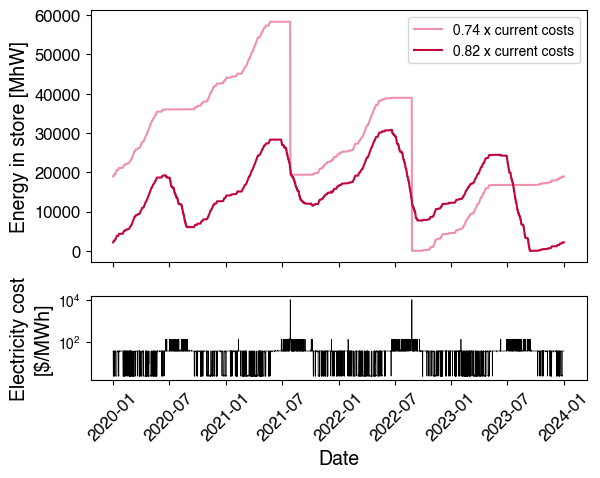

In [8]:
# Collect results
rev_per_inv = {'price_maker': [], 'price_taker': []}
discharge_time = {'price_maker': [], 'price_taker': []}
mean_discharge_time = {'price_maker': [], 'price_taker': []}
inv = {'price_maker': [], 'price_taker': []}
capacity = {'price_maker': [], 'price_taker': []}
capacity_store = {'price_maker': [], 'price_taker': []}
energy_in_store = {'price_maker': [], 'price_taker': []}
gen_capacity = {'price_maker': [], 'price_taker': []}
figure, axis = None, None

# Loop over prices in descending order
for price in prices:
    # Get results
    for run in ['maker', 'taker']:
        result_file = data_path_maker.replace('#COST', str(price)) if run == 'maker' else data_path_taker.replace('#COST', str(price))
        time_input, case_res, comp_res, time_res, btes_cost = read_output_file(result_file)

        # Calculate revenue per investment
        btes_investment = get_btes_investment(comp_res)

        if run =='maker':
            no_btes_file = f'output_data/btes_base_case_orca_no_btes/btes_output_no_btes.pickle'
            if case in ['fossil', 'renewable']: 
                no_btes_file = no_btes_file.replace('.pickle', f'_{case}_costsx{price}.pickle')
            cost_no_btes = read_output_file(no_btes_file)[1]['objective [$]'].values[-1]
            cost = cost_no_btes - (case_res['objective [$]'].values[-1] - btes_investment)
        else:
            cost = abs(case_res['objective [$]'].values[-1] - btes_investment)
        cost = cost / btes_investment
        rev_per_inv['price_maker' if run == 'maker' else 'price_taker'].append(cost)

        # Calculate discharge_time
        granite = comp_res[comp_res.index == ('Store', 'granite')]
        discharger = comp_res[comp_res.index == ('Link', 'BTES_discharger')]
        charger = comp_res[comp_res.index == ('Link', 'BTES_charger')]

        granite_opt_cap = granite['Optimal Capacity [MW]'].values[0]
        discharger_opt_cap = discharger['Optimal Capacity [MW]'].values[0] 
        dur = granite_opt_cap / discharger_opt_cap

        discharge_time['price_maker' if run == 'maker' else 'price_taker'].append(dur)
        # Calculate mean "discharge time" as mean energy in store divided by mean discharge rate
        mean_discharge_time['price_maker' if run == 'maker' else 'price_taker'].append(time_res['granite e'].mean() / time_res['BTES_discharger dispatch'].mean())

        # Get investment
        inv['price_maker' if run == 'maker' else 'price_taker'].append([discharger['Capital Expenditure [$]'].values[0], charger['Capital Expenditure [$]'].values[0], granite['Capital Expenditure [$]'].values[0]])
        
        # Get energy in store
        # Only plot for price taker for values left and right of jump in dispatch time
        plot_factors = ['0p74','0p82']
        if run == 'taker' and price in plot_factors:
            if price == plot_factors[0]:
                col = color_shades['price_taker'][0]
            elif price == plot_factors[1]:
                col = color_shades['price_taker'][2]
            else:
                col = color_shades['price_taker'][1]
            figure, axis = plot_curve_maker_taker(time_res['granite e'], time_input['const_generator marginal cost'] if price == plot_factors[0] else None,
                                   xlabel='Date', ylabel='Energy in store [MhW]', ylabel2='Electricity cost\n[$/MWh]',
                                   color=col, label=price.replace('p','.')+' x current costs',
                                    fig=figure, ax=axis)
        
        # Add optimal capacity for all components

        capacity['price_maker' if run == 'maker' else 'price_taker'].append(discharger_opt_cap)

        capacity_store['price_maker' if run == 'maker' else 'price_taker'].append(granite_opt_cap)

        capacities = comp_res[~comp_res.index.get_level_values(0).isin(['Load', 'Store'])]['Optimal Capacity [MW]']
        # Drop level 0 of index
        capacities.index = capacities.index.droplevel(0)
        gen_capacity['price_maker' if run == 'maker' else 'price_taker'].append(capacities)

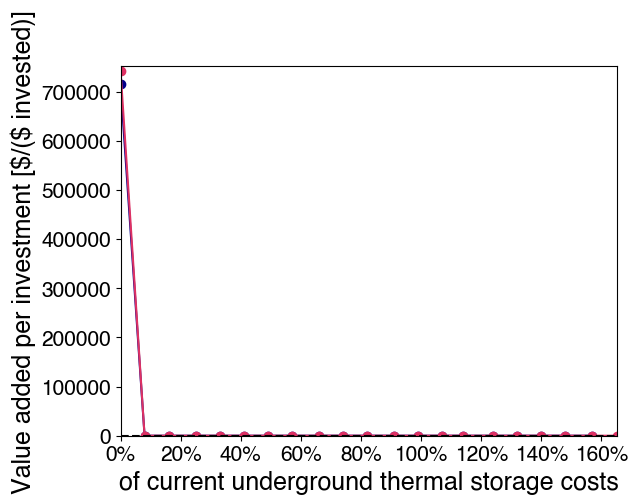

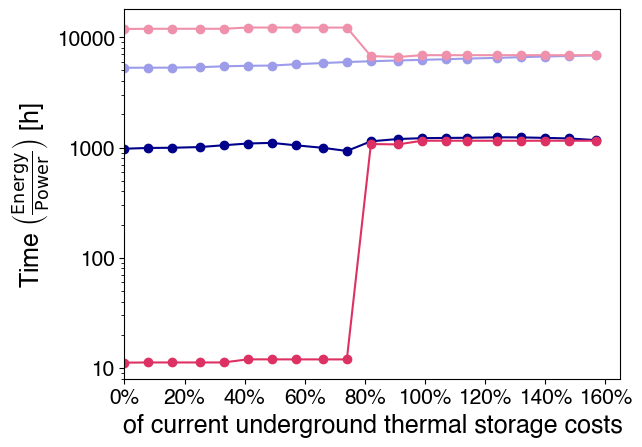

In [9]:
# Replace p with . in prices
prices_float = sorted([float(price.replace('p', '.')) for price in prices])

# Plot revenue per investment
plot_bars_maker_taker(prices_float, rev_per_inv, f'of current {case} costs', 
                      'Value added per investment [$/(\$ invested)]', 'Value added per Investment')
# Plot discharge_time
# Set values in price_taker to nan if they are nan in price_maker
for i, val in enumerate(discharge_time['price_maker']):
    if np.isnan(val):
        discharge_time['price_taker'][i] = np.nan
    # Also in mean_discharge_time
    if np.isnan(mean_discharge_time['price_maker'][i]):
        mean_discharge_time['price_taker'][i] = np.nan
plot_bars_maker_taker(prices_float, discharge_time, f'of current {case} costs', 
                      r'Time $\left(\frac{\mathrm{Energy}}{\mathrm{Power}}\right)$ [h]', 'discharge_time',
                      y2=mean_discharge_time)


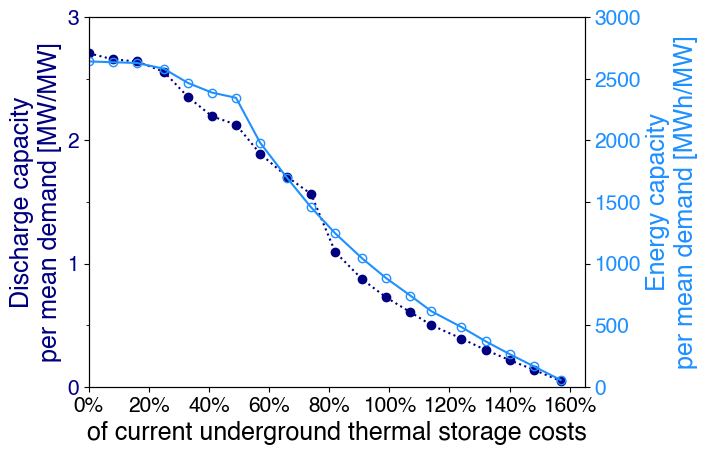

In [10]:
plot_capacity(prices_float, capacity, capacity_store, case)